**Step-1**

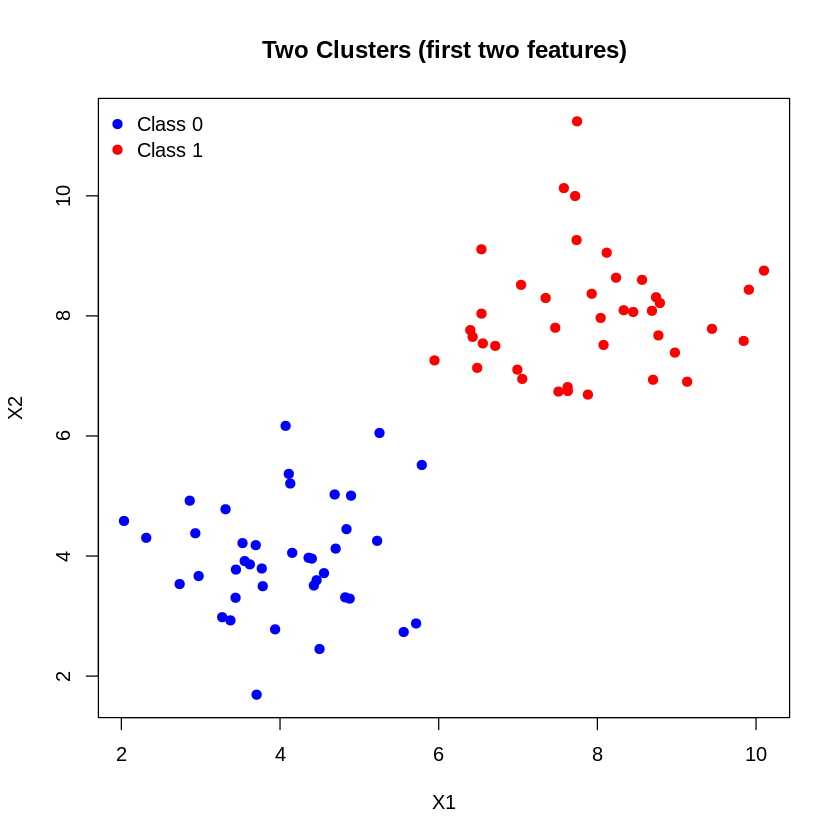

In [ ]:
## ---------------------------
## Step 1 — Data Generation
## ---------------------------
set.seed(123)

# Params (edit freely)
n_obs <- 80           # total observations (must be even)
stopifnot(n_obs %% 2 == 0)
p     <- 3            # number of predictors (m)
sigma <- 1
mu_neg <- rep(4, p)   # class 0 mean
mu_pos <- rep(8, p)   # class 1 mean (increase gap or reduce sigma to ensure clear separation)

# Helper: create one class block
make_block <- function(n_half, mu, sd, p) {
  matrix(rnorm(n_half * p, mean = mu, sd = sd), ncol = p)
}

# Two balanced clusters
X0 <- make_block(n_obs/2, mu_neg, sigma, p)  # class 0
X1 <- make_block(n_obs/2, mu_pos, sigma, p)  # class 1

# Design & target
Xmat <- rbind(X0, X1)
yvec <- c(rep(0, n_obs/2), rep(1, n_obs/2))  # numeric 0/1

# Add intercept, tidy names
Xmat <- cbind(Intercept = 1, Xmat)
colnames(Xmat) <- c("Intercept", paste0("X", 1:p))

# Optional: shuffle rows so classes aren’t ordered
perm <- sample(seq_len(n_obs))
Xmat <- Xmat[perm, , drop = FALSE]
yvec <- yvec[perm]

# Convenience dims
d <- ncol(Xmat)  # includes intercept

# Quick sanity checks
stopifnot(nrow(Xmat) == length(yvec))
stopifnot(all(Xmat[,1] == 1))
stopifnot(sum(yvec == 0) == sum(yvec == 1))

# (Optional) super-simple base R scatter when p >= 2
if (p >= 2) {
  plot(Xmat[,2], Xmat[,3],
       col = ifelse(yvec == 0, "blue", "red"), pch = 19,
       xlab = "X1", ylab = "X2", main = "Two Clusters (first two features)")
  legend("topleft", legend = c("Class 0","Class 1"), col = c("blue","red"), pch = 19, bty = "n")
}


**Step-2**

In [ ]:
## ---------------------------------------
## Step 2 — IRLS / Newton Implementation
## (minimal, no optional extras)
## ---------------------------------------

# Utilities
sigmoid <- function(z) plogis(z)
weighted_xtx <- function(X, w) crossprod(X, w * X)  # fast X'WX via diag(w)

# Settings
tol    <- 1e-6
maxit  <- 100
lambda <- 0      # Step 2 is unregularized
eps    <- 1e-12  # numeric floor/ceiling for probabilities

# Penalty matrix (kept for consistency; no effect when lambda=0)
d <- ncol(Xmat)
penalty <- diag(d); penalty[1,1] <- 0  # no intercept penalty

# Initialize
beta <- rep(0, d)
converged <- FALSE

# IRLS / Newton loop
for (iter in 1:maxit) {
  eta   <- drop(Xmat %*% beta)
  p_hat <- pmin(pmax(sigmoid(eta), eps), 1 - eps)
  w     <- p_hat * (1 - p_hat)                # diagonal weights

  # Score and (negative) Hessian
  score <- crossprod(Xmat, yvec - p_hat) - lambda * (penalty %*% beta)
  Hneg  <- - weighted_xtx(Xmat, w) - lambda * penalty

  # Newton step (stable solve)
  step <- tryCatch(
    - qr.solve(Hneg, score),
    error = function(e) {
      jitter <- 1e-8
      - qr.solve(Hneg - jitter * diag(d), score)
    }
  )

  beta_new <- as.numeric(beta + step)

  # Convergence by max abs step
  if (max(abs(step)) < tol) {
    beta <- beta_new
    cat(sprintf("Converged in %d iterations\n", iter))
    converged <- TRUE
    break
  }

  beta <- beta_new
}

if (!converged) cat(sprintf("Warning: no convergence after %d iterations\n", maxit))

# Coefficients
beta


[1] -372.62031   10.18050   18.46638   33.03887

**Step-3**

In [ ]:
## Use only two predictors (m = 2). If you generated more, subset first 2.
stopifnot(ncol(Xmat) >= 3)  # Intercept + at least 2 features
X2 <- cbind(Intercept = 1, Xmat[, 2:3, drop = FALSE])  # keep intercept + X1,X2
colnames(X2) <- c("Intercept", "X1", "X2")

# y must be numeric 0/1
y <- if (is.numeric(yvec)) yvec else ifelse(yvec %in% c(1, "pos"), 1, 0)

n <- nrow(X2); d2 <- ncol(X2)  # d2 = 3 (β0, β1, β2)


In [ ]:
## IRLS with path tracking (works for any m; here m=2 so d2=3)
irls_logistic_path <- function(X, y, lambda = 0, tol = 1e-6, maxit = 100) {
  n <- nrow(X); d <- ncol(X)
  eps <- 1e-12
  sigmoid <- function(z) plogis(z)
  weighted_xtx <- function(X, w) crossprod(X, w * X)

  # No-penalty for intercept
  P <- diag(d); P[1, 1] <- 0

  beta <- rep(0, d)
  path <- matrix(NA_real_, nrow = maxit + 1, ncol = d)
  path[1, ] <- beta

  for (iter in 1:maxit) {
    eta   <- drop(X %*% beta)
    p_hat <- pmin(pmax(sigmoid(eta), eps), 1 - eps)
    w     <- p_hat * (1 - p_hat)

    score <- crossprod(X, y - p_hat) - lambda * (P %*% beta)
    Hneg  <- - weighted_xtx(X, w) - lambda * P

    step <- tryCatch(
      - qr.solve(Hneg, score),
      error = function(e) { - qr.solve(Hneg - 1e-8 * diag(d), score) }
    )

    beta_new <- as.numeric(beta + step)

    # Convergence
    if (max(abs(step)) < tol) {
      beta <- beta_new
      path[iter + 1, ] <- beta
      path <- path[!apply(is.na(path), 1, all), , drop = FALSE]
      return(list(beta = beta, path = path, iter = iter, lambda = lambda))
    }

    beta <- beta_new
    path[iter + 1, ] <- beta
  }

  path <- path[!apply(is.na(path), 1, all), , drop = FALSE]
  warning(sprintf("IRLS did not strictly converge in %d iterations (lambda=%.3g)", maxit, lambda))
  list(beta = beta, path = path, iter = maxit, lambda = lambda)
}


In [ ]:
## (a) Unregularized
fit_unreg <- irls_logistic_path(X2, y, lambda = 0)

## (b) L2-regularized (choose a visible lambda; adjust if needed)
lambda_ridge <- 1
fit_ridge <- irls_logistic_path(X2, y, lambda = lambda_ridge)

fit_unreg$beta
fit_ridge$beta

Warning message in irls_logistic_path(X2, y, lambda = 0):
“IRLS did not strictly converge in 100 iterations (lambda=0)”


[1] -469.96385   27.74405   47.88139

[1] -17.200689   1.374185   1.472836

In [ ]:
# Helpers
slope      <- function(b) -b[2] / b[3]
x2_at_x1_0 <- function(b) -b[1] / b[3]
coef_norm  <- function(b) sqrt(sum(b[-1]^2))               # L2 norm excluding intercept
predict_label <- function(X, beta) as.integer(plogis(drop(X %*% beta)) >= 0.5)
conf_mat <- function(y_true, y_pred) {
  tab <- table(factor(y_true, levels = c(0,1)), factor(y_pred, levels = c(0,1)))
  dimnames(tab) <- list(True = c("0","1"), Pred = c("0","1"))
  tab
}
summarize_model <- function(name, beta, X, y) {
  cat("\n============================\n")
  cat(sprintf("%s\n", name))
  cat("============================\n")
  cat(sprintf("β: %s\n", paste(round(beta, 6), collapse = ", ")))
  cat(sprintf("Slope (−β1/β2): %.6f\n", slope(beta)))
  cat(sprintf("x2-cut at x1=0 (−β0/β2): %.6f\n", x2_at_x1_0(beta)))
  cat(sprintf("‖β‖₂ (no intercept): %.6f\n", coef_norm(beta)))
  yhat <- predict_label(X, beta)
  acc  <- mean(yhat == y)
  cat(sprintf("Accuracy (on Step-3 set): %.2f%%\n", 100 * acc))
  print(conf_mat(y, yhat))
  invisible(list(yhat = yhat, acc = acc))
}

res_unreg <- summarize_model(
  sprintf("Unregularized (λ=0)"),
  fit_unreg$beta, X2, y
)

res_ridge <- summarize_model(
  sprintf("Ridge (λ=%.2g)", lambda_ridge),
  fit_ridge$beta, X2, y
)



Unregularized (λ=0)
β: -469.963846, 27.744048, 47.881389
Slope (−β1/β2): -0.579433
x2-cut at x1=0 (−β0/β2): 9.815167
‖β‖₂ (no intercept): 55.338591
Accuracy (on Step-3 set): 100.00%
    Pred
True  0  1
   0 40  0
   1  0 40

Ridge (λ=1)
β: -17.200689, 1.374185, 1.472836
Slope (−β1/β2): -0.933020
x2-cut at x1=0 (−β0/β2): 11.678621
‖β‖₂ (no intercept): 2.014356
Accuracy (on Step-3 set): 100.00%
    Pred
True  0  1
   0 40  0
   1  0 40


[1] -469.96385   27.74405   47.88139

[1] -17.200689   1.374185   1.472836

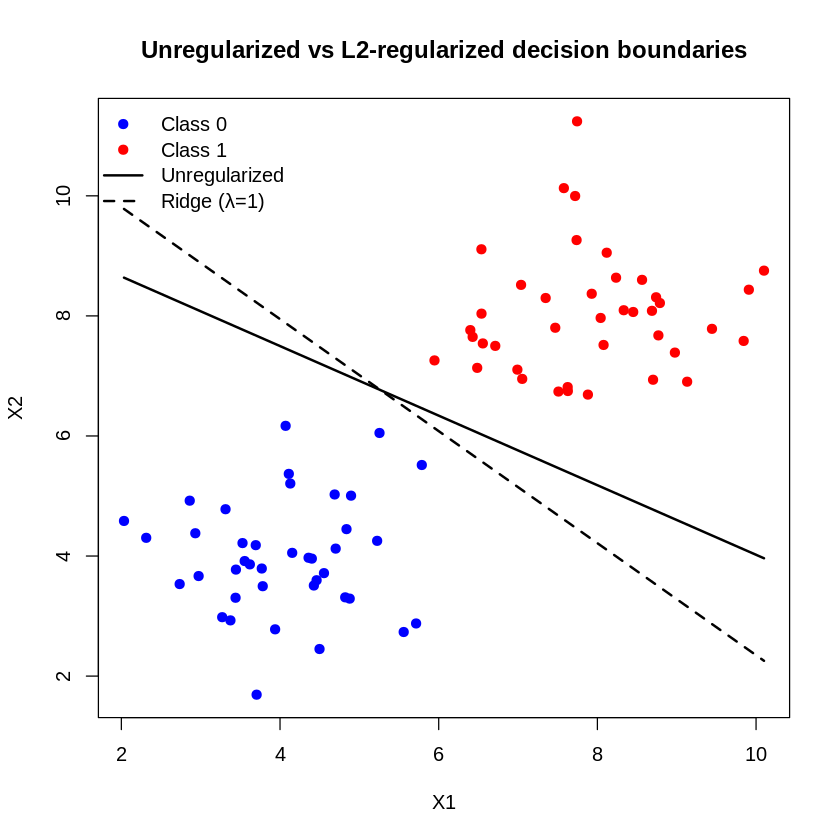

In [ ]:
## Scatter and boundaries (base R)
plot(X2[, "X1"], X2[, "X2"],
     col = ifelse(y == 0, "blue", "red"), pch = 19,
     xlab = "X1", ylab = "X2",
     main = "Unregularized vs L2-regularized decision boundaries")

# Helper to draw boundary line
draw_boundary <- function(beta, x_range, ...) {
  b0 <- beta[1]; b1 <- beta[2]; b2 <- beta[3]
  if (abs(b2) < 1e-12) return(invisible(NULL))
  xx <- seq(x_range[1], x_range[2], length.out = 100)
  yy <- -(b0 + b1 * xx) / b2
  lines(xx, yy, ...)
}

xr <- range(X2[, "X1"]); yr <- range(X2[, "X2"])
# Unregularized (solid)
draw_boundary(fit_unreg$beta, xr, lwd = 2)
# Regularized (dashed)
draw_boundary(fit_ridge$beta, xr, lwd = 2, lty = 2)

legend("topleft",
       legend = c("Class 0", "Class 1", "Unregularized", sprintf("Ridge (λ=%.2g)", lambda_ridge)),
       col = c("blue", "red", "black", "black"),
       pch = c(19, 19, NA, NA),
       lty = c(NA, NA, 1, 2),
       lwd = c(NA, NA, 2, 2),
       bty = "n")
fit_unreg$beta
fit_ridge$beta


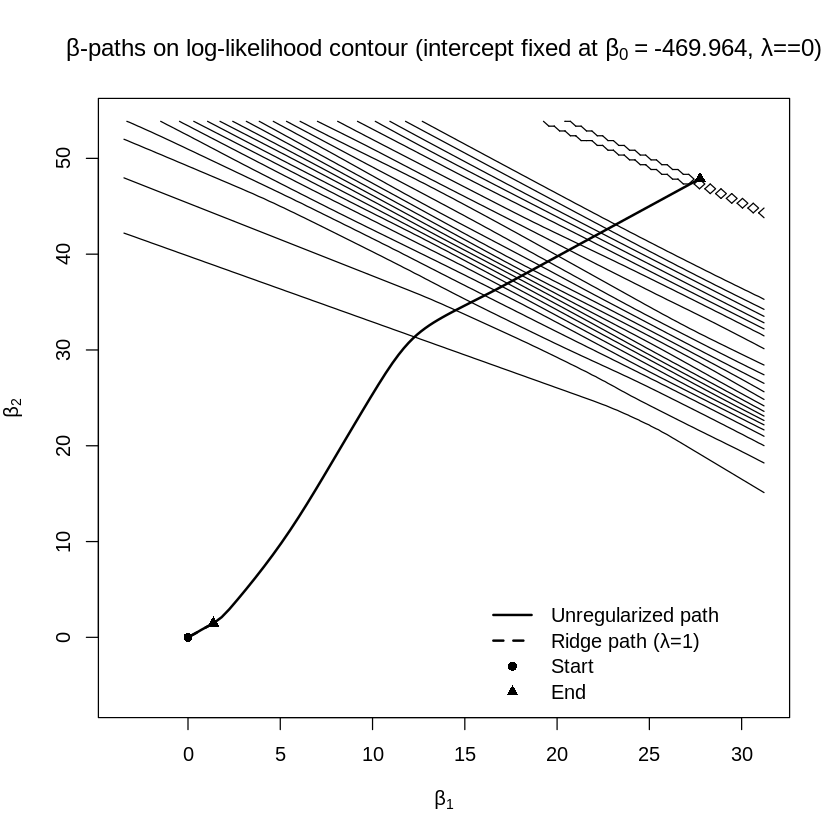

In [ ]:
## Build a grid in (β1, β2) around the paths
path_all <- rbind(fit_unreg$path, fit_ridge$path)
b1_vals <- path_all[, 2]; b2_vals <- path_all[, 3]
b0_fix  <- fit_unreg$beta[1]  # fix intercept to unregularized solution for the contour

pad <- function(v, frac = 0.25) { rng <- range(v); mid <- mean(rng); half <- diff(rng)/2;
                                  if (half == 0) { half <- 1 }
                                  c(mid - (1+frac)*half, mid + (1+frac)*half) }
b1_rng <- pad(b1_vals)
b2_rng <- pad(b2_vals)

g1 <- seq(b1_rng[1], b1_rng[2], length.out = 120)
g2 <- seq(b2_rng[1], b2_rng[2], length.out = 120)

# Penalized log-likelihood function for grid (fix β0)
loglik_grid <- function(b1, b2, b0, X, y, lambda) {
  eta <- b0 + b1 * X[, "X1"] + b2 * X[, "X2"]
  p   <- plogis(eta)
  ll  <- sum(y * log(p + 1e-12) + (1 - y) * log(1 - p + 1e-12))
  # Ridge penalty does NOT include intercept; here only penalize b1,b2
  ll - 0.5 * lambda * (b1^2 + b2^2)
}

# Choose which λ to show the contour for. Often λ = 0 (unregularized) is insightful.
lambda_contour <- 0

Z <- outer(g1, g2, Vectorize(function(b1, b2)
  loglik_grid(b1, b2, b0_fix, X2, y, lambda_contour)
))

# Make the contour plot
contour(g1, g2, Z,
        nlevels = 20, drawlabels = FALSE,
        xlab = expression(beta[1]), ylab = expression(beta[2]),
        main = bquote("β-paths on " * log * "-likelihood contour (intercept fixed at " *
                       beta[0] == .(round(b0_fix, 3)) * ", λ==" * .(lambda_contour) * ")"))

# Overlay β-paths (project (β1,β2))
lines(fit_unreg$path[, 2], fit_unreg$path[, 3], lwd = 2)
points(fit_unreg$path[1, 2], fit_unreg$path[1, 3], pch = 16)   # start
points(fit_unreg$path[nrow(fit_unreg$path), 2],
       fit_unreg$path[nrow(fit_unreg$path), 3], pch = 17)      # end

lines(fit_ridge$path[, 2], fit_ridge$path[, 3], lwd = 2, lty = 2)
points(fit_ridge$path[1, 2], fit_ridge$path[1, 3], pch = 16)
points(fit_ridge$path[nrow(fit_ridge$path), 2],
       fit_ridge$path[nrow(fit_ridge$path), 3], pch = 17)

legend("bottomright",
       legend = c("Unregularized path", sprintf("Ridge path (λ=%.2g)", lambda_ridge),
                  "Start", "End"),
       lty    = c(1, 2, NA, NA),
       pch    = c(NA, NA, 16, 17),
       lwd    = c(2, 2, NA, NA),
       bty    = "n")


**Step-4**

In [ ]:
## ------------------------------------------------------
## Block 0 — Setup for m = 2 and label formatting
## ------------------------------------------------------
# Ensure we have at least two predictors + intercept
stopifnot(ncol(Xmat) >= 3)

# Keep intercept + first two features only (m = 2)
X2 <- cbind(Intercept = 1, X1 = Xmat[, 2], X2 = Xmat[, 3])

# Ensure numeric 0/1 labels
y <- if (is.numeric(yvec)) yvec else ifelse(yvec %in% c(1, "pos"), 1, 0)
stopifnot(length(y) == nrow(X2))

# Helper to compute class-wise means in (X1, X2)
class_means <- function(X, y) {
  c0 <- colMeans(X[y == 0, c("X1","X2"), drop = FALSE])
  c1 <- colMeans(X[y == 1, c("X1","X2"), drop = FALSE])
  list(mu0 = c0, mu1 = c1)
}


In [ ]:
## ------------------------------------------------------
## Block 1 — Add outliers to break linear separability
## ------------------------------------------------------
set.seed(42)

cms <- class_means(X2, y)
k           <- 5      # number of outliers per class
jitter_sd   <- 0.4    # spread around the opposite cluster center

# Class-0 outliers near class-1 center (invade class 1 region)
o0 <- cbind(
  Intercept = 1,
  X1 = rnorm(k, mean = cms$mu1[1], sd = jitter_sd),
  X2 = rnorm(k, mean = cms$mu1[2], sd = jitter_sd)
)
y0 <- rep(0, k)

# Class-1 outliers near class-0 center
o1 <- cbind(
  Intercept = 1,
  X1 = rnorm(k, mean = cms$mu0[1], sd = jitter_sd),
  X2 = rnorm(k, mean = cms$mu0[2], sd = jitter_sd)
)
y1 <- rep(1, k)

# Augment
X2_out <- rbind(X2, o0, o1)
y_out  <- c(y, y0, y1)

# Indices of added outliers (for plotting/highlight)
idx_out <- (nrow(X2) + 1):nrow(X2_out)

cat(sprintf("Added %d outliers (total now %d rows)\n", length(idx_out), nrow(X2_out)))


Added 10 outliers (total now 90 rows)


In [ ]:
## ------------------------------------------------------
## Block 2 — IRLS (Newton) routine
##           (works for both λ=0 and λ>0; no intercept penalty)
## ------------------------------------------------------
irls_logistic <- function(X, y, lambda = 0, tol = 1e-6, maxit = 200) {
  n <- nrow(X); d <- ncol(X)
  eps <- 1e-12
  sigmoid <- function(z) plogis(z)
  weighted_xtx <- function(X, w) crossprod(X, w * X)

  P <- diag(d); P[1, 1] <- 0  # no penalty on intercept
  beta <- rep(0, d)

  for (iter in 1:maxit) {
    eta   <- drop(X %*% beta)
    p_hat <- pmin(pmax(sigmoid(eta), eps), 1 - eps)
    w     <- p_hat * (1 - p_hat)

    score <- crossprod(X, y - p_hat) - lambda * (P %*% beta)
    Hneg  <- - weighted_xtx(X, w) - lambda * P

    step <- tryCatch(
      - qr.solve(Hneg, score),
      error = function(e) - qr.solve(Hneg - 1e-8 * diag(d), score)
    )

    beta_new <- as.numeric(beta + step)
    if (max(abs(step)) < tol) {
      return(list(beta = beta_new, iter = iter, lambda = lambda, converged = TRUE))
    }
    beta <- beta_new
  }
  warning(sprintf("IRLS did not strictly converge in %d iterations (lambda=%g)", maxit, lambda))
  list(beta = beta, iter = maxit, lambda = lambda, converged = FALSE)
}


In [ ]:
## ------------------------------------------------------
## Block 3 — Fit both models on outlier-augmented data
## ------------------------------------------------------
fit_unreg_o <- irls_logistic(X2_out, y_out, lambda = 0)     # (i) unregularized
lambda_ridge <- 1
fit_ridge_o  <- irls_logistic(X2_out, y_out, lambda = lambda_ridge)  # (ii) ridge

cat("Unregularized β (λ=0):\n");   print(round(fit_unreg_o$beta, 6))
cat("Ridge β        (λ=1):\n");   print(round(fit_ridge_o$beta, 6))


Unregularized β (λ=0):
[1] -5.847700  0.617686  0.360694
Ridge β        (λ=1):
[1] -5.752562  0.590484  0.371757


In [ ]:
## ------------------------------------------------------
## Block 4 — Results for each model: slopes, boundary eqs,
##           coefficient norms, predictions, confusion, accuracy
## ------------------------------------------------------
# Helpers
slope      <- function(b) -b[2] / b[3]
x2_at_x1_0 <- function(b) -b[1] / b[3]   # intercept in x2 when x1 = 0
coef_norm  <- function(b) sqrt(sum(b[-1]^2))  # L2 norm excluding intercept
predict_label <- function(X, beta) as.integer(plogis(drop(X %*% beta)) >= 0.5)
conf_mat <- function(y_true, y_pred) {
  tab <- table(factor(y_true, levels = c(0,1)), factor(y_pred, levels = c(0,1)))
  dimnames(tab) <- list(True = c("0","1"), Pred = c("0","1"))
  tab
}

summarize_model <- function(name, beta, X, y) {
  cat("\n----------------------------\n")
  cat(sprintf("%s\n", name))
  cat("----------------------------\n")
  cat(sprintf("β: %s\n", paste(round(beta, 6), collapse = ", ")))
  cat(sprintf("Slope (−β1/β2): %.6f\n", slope(beta)))
  cat(sprintf("x2-cut at x1=0 (−β0/β2): %.6f\n", x2_at_x1_0(beta)))
  cat(sprintf("‖β‖₂ (no intercept): %.6f\n", coef_norm(beta)))
  yhat <- predict_label(X, beta)
  acc  <- mean(yhat == y)
  cat(sprintf("Accuracy (on outlier-augmented set): %.2f%%\n", 100 * acc))
  print(conf_mat(y, yhat))
  invisible(list(yhat = yhat, acc = acc))
}

res_unreg <- summarize_model(
  sprintf("Unregularized (λ=0)"),
  fit_unreg_o$beta, X2_out, y_out
)

res_ridge <- summarize_model(
  sprintf("Ridge (λ=%g)", lambda_ridge),
  fit_ridge_o$beta, X2_out, y_out
)



----------------------------
Unregularized (λ=0)
----------------------------
β: -5.8477, 0.617686, 0.360694
Slope (−β1/β2): -1.712495
x2-cut at x1=0 (−β0/β2): 16.212364
‖β‖₂ (no intercept): 0.715288
Accuracy (on outlier-augmented set): 88.89%
    Pred
True  0  1
   0 40  5
   1  5 40

----------------------------
Ridge (λ=1)
----------------------------
β: -5.752562, 0.590484, 0.371757
Slope (−β1/β2): -1.588360
x2-cut at x1=0 (−β0/β2): 15.473973
‖β‖₂ (no intercept): 0.697764
Accuracy (on outlier-augmented set): 88.89%
    Pred
True  0  1
   0 40  5
   1  5 40


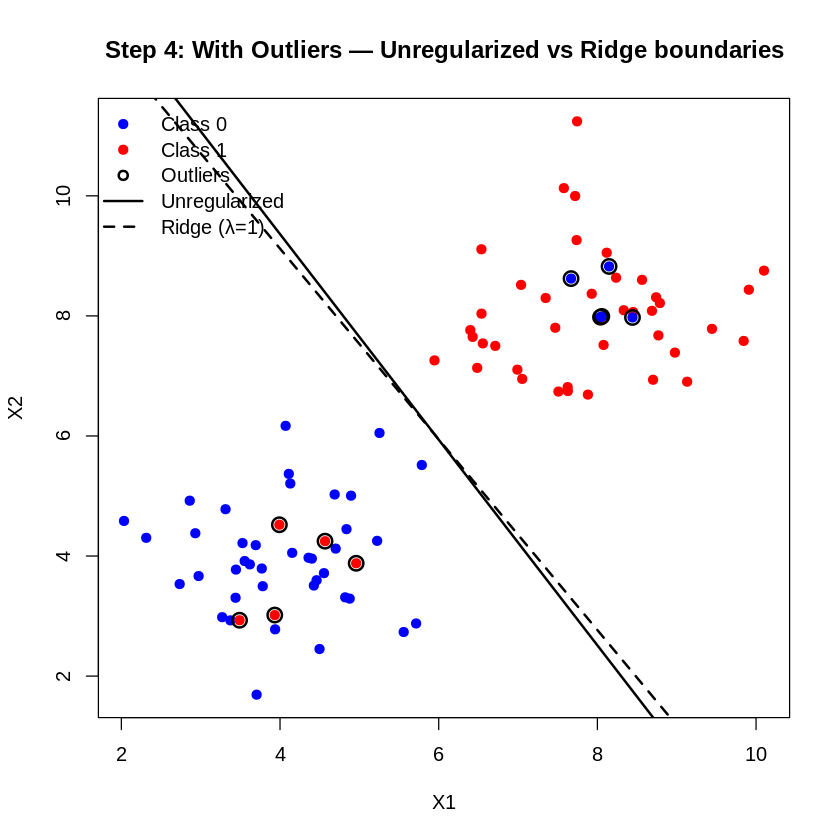

In [ ]:
## ------------------------------------------------------
## Block 5 — Plot with BOTH decision boundaries and outliers
## ------------------------------------------------------
# Scatter (base R)
cols <- ifelse(y_out == 0, "blue", "red")
plot(X2_out[, "X1"], X2_out[, "X2"],
     col = cols, pch = 19,
     xlab = "X1", ylab = "X2",
     main = "Step 4: With Outliers — Unregularized vs Ridge boundaries")

# Highlight added outliers
points(X2_out[idx_out, "X1"], X2_out[idx_out, "X2"], pch = 1, cex = 1.6, lwd = 2)

# Decision boundary helper: p = 0.5 → β0 + β1 x1 + β2 x2 = 0 ⇒ x2 = −(β0 + β1 x1)/β2
draw_boundary <- function(beta, x_range, ...) {
  b0 <- beta[1]; b1 <- beta[2]; b2 <- beta[3]
  if (abs(b2) < 1e-12) return(invisible(NULL))
  xx <- seq(x_range[1], x_range[2], length.out = 200)
  yy <- -(b0 + b1 * xx) / b2
  lines(xx, yy, ...)
}

xr <- range(X2_out[, "X1"])
draw_boundary(fit_unreg_o$beta, xr, lwd = 2)          # solid = unregularized
draw_boundary(fit_ridge_o$beta,  xr, lwd = 2, lty = 2) # dashed = ridge

legend("topleft",
       legend = c("Class 0", "Class 1", "Outliers", "Unregularized", sprintf("Ridge (λ=%g)", lambda_ridge)),
       col    = c("blue", "red", "black", "black", "black"),
       pch    = c(19, 19, 1, NA, NA),
       lty    = c(NA, NA, NA, 1, 2),
       lwd    = c(NA, NA, 2, 2, 2),
       bty    = "n")


**Step-5**

In [ ]:
## ------------------------------------------------------
## Block 1 — Scenario grid: (A) m=2 and (B) m>2
##            small vs large; balanced vs imbalanced
## ------------------------------------------------------

# You can tweak these to your liking
m_set        <- c(2, 5)           # (A) m=2; (B) m>2 (example m=5)
n_small      <- 60                # small dataset
n_large      <- 400               # large dataset
pi_balanced  <- 0.5               # balanced: n1 = n2 (approx for odd n)
pi_imbalanced<- 0.7               # imbalanced: ~70% class 1

# Models to run per scenario
lambdas <- c(0, 1)                # 0 = unregularized; 1 = ridge (adjust as desired)

# Build scenario list
scenarios <- list(
  list(m = 2, n = n_small, pi1 = pi_balanced,   label = "m=2, small, balanced"),
  list(m = 2, n = n_large, pi1 = pi_balanced,   label = "m=2, large, balanced"),
  list(m = 2, n = n_small, pi1 = pi_imbalanced, label = "m=2, small, imbalanced"),
  list(m = 2, n = n_large, pi1 = pi_imbalanced, label = "m=2, large, imbalanced"),
  list(m = 5, n = n_small, pi1 = pi_balanced,   label = "m=5, small, balanced"),
  list(m = 5, n = n_large, pi1 = pi_balanced,   label = "m=5, large, balanced"),
  list(m = 5, n = n_small, pi1 = pi_imbalanced, label = "m=5, small, imbalanced"),
  list(m = 5, n = n_large, pi1 = pi_imbalanced, label = "m=5, large, imbalanced")
)


In [ ]:
## ------------------------------------------------------
## Block 2 — Run all scenarios, fit both models, collect results
## ------------------------------------------------------

all_results <- list()

for (sc in scenarios) {
  m   <- sc$m
  n   <- sc$n
  pi1 <- sc$pi1
  lbl <- sc$label

  dat <- gen_two_cluster(n = n, m = m, pi1 = pi1, mu0 = 4, mu1 = 8, sigma = 1)
  X   <- dat$X
  y   <- dat$y

  cat(sprintf("\n=== Scenario: %s ===\n", lbl))
  cat(sprintf("Dims: n=%d, m=%d  |  class1 share=%.2f\n", n, m, pi1))

  for (lam in lambdas) {
    fit <- irls_logistic(X, y, lambda = lam, tol = 1e-6, maxit = 200)

    model_name <- if (lam == 0) "Unregularized" else "Ridge"
    res_row <- summarize_fit(
      beta = fit$beta, X = X, y = y,
      model_name = model_name, m = m, n = n, pi1 = pi1,
      lambda = lam, iter = fit$iter, converged = fit$converged
    )
    print(res_row)
    all_results[[length(all_results) + 1]] <- res_row
  }
}

results_df <- do.call(rbind, all_results)

# Neat view
results_df[order(results_df$m, results_df$n, results_df$pi1, results_df$lambda), ]



=== Scenario: m=2, small, balanced ===
Dims: n=60, m=2  |  class1 share=0.50


Warning message in irls_logistic(X, y, lambda = lam, tol = 1e-06, maxit = 200):
“IRLS did not strictly converge in 200 iterations (lambda=0)”


          model lambda m  n pi1 converged iter beta_norm acc_full
1 Unregularized      0 2 60 0.5     FALSE  200  88.46134        1
  model lambda m  n pi1 converged iter beta_norm acc_full
1 Ridge      1 2 60 0.5      TRUE    8  1.881117        1

=== Scenario: m=2, large, balanced ===
Dims: n=400, m=2  |  class1 share=0.50
          model lambda m   n pi1 converged iter beta_norm acc_full
1 Unregularized      0 2 400 0.5      TRUE   12   4.61481   0.9975
  model lambda m   n pi1 converged iter beta_norm acc_full
1 Ridge      1 2 400 0.5      TRUE   10  2.722892   0.9975

=== Scenario: m=2, small, imbalanced ===
Dims: n=60, m=2  |  class1 share=0.70


Warning message in irls_logistic(X, y, lambda = lam, tol = 1e-06, maxit = 200):
“IRLS did not strictly converge in 200 iterations (lambda=0)”


          model lambda m  n pi1 converged iter beta_norm acc_full
1 Unregularized      0 2 60 0.7     FALSE  200  98.26012        1
  model lambda m  n pi1 converged iter beta_norm acc_full
1 Ridge      1 2 60 0.7      TRUE    8  1.806102        1

=== Scenario: m=2, large, imbalanced ===
Dims: n=400, m=2  |  class1 share=0.70


Warning message in irls_logistic(X, y, lambda = lam, tol = 1e-06, maxit = 200):
“IRLS did not strictly converge in 200 iterations (lambda=0)”


          model lambda m   n pi1 converged iter beta_norm acc_full
1 Unregularized      0 2 400 0.7     FALSE  200   106.052        1
  model lambda m   n pi1 converged iter beta_norm acc_full
1 Ridge      1 2 400 0.7      TRUE   10  2.736491        1

=== Scenario: m=5, small, balanced ===
Dims: n=60, m=5  |  class1 share=0.50


Warning message in irls_logistic(X, y, lambda = lam, tol = 1e-06, maxit = 200):
“IRLS did not strictly converge in 200 iterations (lambda=0)”


          model lambda m  n pi1 converged iter beta_norm acc_full
1 Unregularized      0 5 60 0.5     FALSE  200  50.05147        1
  model lambda m  n pi1 converged iter beta_norm acc_full
1 Ridge      1 5 60 0.5      TRUE    9  1.333338        1

=== Scenario: m=5, large, balanced ===
Dims: n=400, m=5  |  class1 share=0.50


Warning message in irls_logistic(X, y, lambda = lam, tol = 1e-06, maxit = 200):
“IRLS did not strictly converge in 200 iterations (lambda=0)”


          model lambda m   n pi1 converged iter beta_norm acc_full
1 Unregularized      0 5 400 0.5     FALSE  200  48.99756        1
  model lambda m   n pi1 converged iter beta_norm acc_full
1 Ridge      1 5 400 0.5      TRUE   11  1.781777        1

=== Scenario: m=5, small, imbalanced ===
Dims: n=60, m=5  |  class1 share=0.70


Warning message in irls_logistic(X, y, lambda = lam, tol = 1e-06, maxit = 200):
“IRLS did not strictly converge in 200 iterations (lambda=0)”


          model lambda m  n pi1 converged iter beta_norm acc_full
1 Unregularized      0 5 60 0.7     FALSE  200  48.03282        1
  model lambda m  n pi1 converged iter beta_norm acc_full
1 Ridge      1 5 60 0.7      TRUE    9  1.305041        1

=== Scenario: m=5, large, imbalanced ===
Dims: n=400, m=5  |  class1 share=0.70


Warning message in irls_logistic(X, y, lambda = lam, tol = 1e-06, maxit = 200):
“IRLS did not strictly converge in 200 iterations (lambda=0)”


          model lambda m   n pi1 converged iter beta_norm acc_full
1 Unregularized      0 5 400 0.7     FALSE  200   49.6955        1
  model lambda m   n pi1 converged iter beta_norm acc_full
1 Ridge      1 5 400 0.7      TRUE   11  1.763551        1


,model,lambda,m,n,pi1,converged,iter,beta_norm,acc_full
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
1,Unregularized,0,2,60,0.5,FALSE,200,88.461342,1.0000
2,Ridge,1,2,60,0.5,TRUE,8,1.881117,1.0000
5,Unregularized,0,2,60,0.7,FALSE,200,98.260124,1.0000
6,Ridge,1,2,60,0.7,TRUE,8,1.806102,1.0000
3,Unregularized,0,2,400,0.5,TRUE,12,4.614810,0.9975
4,Ridge,1,2,400,0.5,TRUE,10,2.722892,0.9975
7,Unregularized,0,2,400,0.7,FALSE,200,106.052038,1.0000
8,Ridge,1,2,400,0.7,TRUE,10,2.736491,1.0000
9,Unregularized,0,5,60,0.5,FALSE,200,50.051468,1.0000


**Step-6**

In [ ]:
## Step 6 — Core utils
set.seed(2025)

# IRLS (intercept unpenalized)
irls_logistic <- function(X, y, lambda = 0, tol = 1e-6, maxit = 300) {
  n <- nrow(X); d <- ncol(X)
  eps <- 1e-12
  sigmoid <- function(z) plogis(z)
  wxwx <- function(X, w) crossprod(X, w * X)
  P <- diag(d); P[1,1] <- 0
  beta <- rep(0, d); converged <- FALSE; iters <- NA_integer_

  for (iter in 1:maxit) {
    eta   <- drop(X %*% beta)
    p_hat <- pmin(pmax(sigmoid(eta), eps), 1 - eps)
    w     <- p_hat * (1 - p_hat)

    score <- crossprod(X, y - p_hat) - lambda * (P %*% beta)
    Hneg  <- - wxwx(X, w) - lambda * P

    step <- tryCatch(
      - qr.solve(Hneg, score),
      error = function(e) - qr.solve(Hneg - 1e-8 * diag(d), score)
    )
    beta_new <- as.numeric(beta + step)
    if (max(abs(step)) < tol) { beta <- beta_new; converged <- TRUE; iters <- iter; break }
    beta <- beta_new; iters <- iter
  }
  if (!converged) warning(sprintf("IRLS did not strictly converge in %d iterations (lambda=%g)", maxit, lambda))
  list(beta = beta, converged = converged, iter = iters, lambda = lambda)
}

# Stratified 80/20 split
split_80_20 <- function(X, y) {
  idx1 <- which(y == 1); idx0 <- which(y == 0)
  n1_tr <- max(1, floor(length(idx1) * 0.8))
  n0_tr <- max(1, floor(length(idx0) * 0.8))
  tr_idx <- c(sample(idx1, n1_tr), sample(idx0, n0_tr))
  te_idx <- setdiff(seq_len(length(y)), tr_idx)
  list(
    Xtr = X[tr_idx, , drop = FALSE], ytr = y[tr_idx],
    Xte = X[te_idx, , drop = FALSE], yte = y[te_idx],
    tr_idx = tr_idx, te_idx = te_idx
  )
}

# Metrics + scenario evaluator
predict_label <- function(X, beta) as.integer(plogis(drop(X %*% beta)) >= 0.5)
accu <- function(y_true, y_pred) mean(y_true == y_pred)
coef_norm_L2 <- function(beta) sqrt(sum(beta[-1]^2))  # exclude intercept

evaluate_scenario <- function(X, y, scenario_name, lambda_ridge = 1, scale_features = FALSE) {
  stopifnot(nrow(X) == length(y))
  X_use <- X
  if (scale_features) X_use[, -1] <- scale(X_use[, -1], center = TRUE, scale = TRUE)

  spl <- split_80_20(X_use, y)
  rows <- list()
  for (lam in c(0, lambda_ridge)) {
    fit_tr <- irls_logistic(spl$Xtr, spl$ytr, lambda = lam)
    yhat_tr <- predict_label(spl$Xtr, fit_tr$beta)
    yhat_te <- predict_label(spl$Xte, fit_tr$beta)
    rows[[length(rows) + 1]] <- data.frame(
      scenario   = scenario_name,
      model      = if (lam == 0) "Unregularized" else sprintf("Ridge(λ=%g)", lam),
      m          = ncol(X) - 1,
      n_train    = nrow(spl$Xtr),
      n_test     = nrow(spl$Xte),
      pos_train  = sum(spl$ytr == 1),
      pos_test   = sum(spl$yte == 1),
      beta_norm  = round(coef_norm_L2(fit_tr$beta), 6),
      iter       = fit_tr$iter,
      converged  = fit_tr$converged,
      acc_train  = round(accu(spl$ytr, yhat_tr), 4),
      acc_test   = round(accu(spl$yte, yhat_te), 4),
      stringsAsFactors = FALSE
    )
  }
  do.call(rbind, rows)
}


In [ ]:
## Step 3 scenario (m=2, clean)
stopifnot(exists("Xmat"), exists("yvec"))
y_num <- if (is.numeric(yvec)) yvec else ifelse(yvec %in% c(1,"pos"), 1, 0)

stopifnot(ncol(Xmat) >= 3)
X2 <- cbind(Intercept = 1, X1 = Xmat[,2], X2 = Xmat[,3])

res_step3 <- evaluate_scenario(
  X = X2, y = y_num,
  scenario_name = "Step3: m=2, clean (separable)",
  lambda_ridge = 1,
  scale_features = FALSE
)


Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”


In [ ]:
## Step 4 scenario (m=2, with outliers)
set.seed(42)
mu0 <- colMeans(X2[y_num == 0, c("X1","X2"), drop = FALSE])
mu1 <- colMeans(X2[y_num == 1, c("X1","X2"), drop = FALSE])

k <- 3; jitter_sd <- 0.4
o0 <- cbind(Intercept = 1,
            X1 = rnorm(k, mean = mu1[1], sd = jitter_sd),
            X2 = rnorm(k, mean = mu1[2], sd = jitter_sd))
y0 <- rep(0, k)
o1 <- cbind(Intercept = 1,
            X1 = rnorm(k, mean = mu0[1], sd = jitter_sd),
            X2 = rnorm(k, mean = mu0[2], sd = jitter_sd))
y1 <- rep(1, k)

X2_out <- rbind(X2, o0, o1)
y_out  <- c(y_num, y0, y1)

res_step4 <- evaluate_scenario(
  X = X2_out, y = y_out,
  scenario_name = "Step4: m=2, with outliers (non-separable)",
  lambda_ridge = 1,
  scale_features = FALSE
)


In [ ]:
## Step 5 scenarios
gen_two_cluster <- function(n, m, pi1 = 0.5, mu0 = 4, mu1 = 8, sigma = 1) {
  n1 <- round(n * pi1); n0 <- n - n1
  X0 <- matrix(rnorm(n0 * m, mean = mu0, sd = sigma), ncol = m)
  X1 <- matrix(rnorm(n1 * m, mean = mu1, sd = sigma), ncol = m)
  X   <- rbind(X0, X1)
  y   <- c(rep(0, n0), rep(1, n1))
  X   <- cbind(Intercept = 1, X)
  colnames(X) <- c("Intercept", paste0("X", 1:m))
  perm <- sample(seq_len(n))
  list(X = X[perm, , drop = FALSE], y = y[perm])
}

m_vals <- c(2, 5)
n_small <- 60; n_large <- 400
pi_bal <- 0.5; pi_imb <- 0.7

scenarios <- list(
  list(m=2, n=n_small, pi1=pi_bal, label="Step5: m=2, small, balanced"),
  list(m=2, n=n_large, pi1=pi_bal, label="Step5: m=2, large, balanced"),
  list(m=2, n=n_small, pi1=pi_imb, label="Step5: m=2, small, imbalanced"),
  list(m=2, n=n_large, pi1=pi_imb, label="Step5: m=2, large, imbalanced"),
  list(m=5, n=n_small, pi1=pi_bal, label="Step5: m=5, small, balanced"),
  list(m=5, n=n_large, pi1=pi_bal, label="Step5: m=5, large, balanced"),
  list(m=5, n=n_small, pi1=pi_imb, label="Step5: m=5, small, imbalanced"),
  list(m=5, n=n_large, pi1=pi_imb, label="Step5: m=5, large, imbalanced")
)

res_step5_list <- list()
for (sc in scenarios) {
  dat <- gen_two_cluster(sc$n, sc$m, sc$pi1, mu0 = 4, mu1 = 8, sigma = 1)
  res_step5_list[[length(res_step5_list) + 1]] <- evaluate_scenario(
    X = dat$X, y = dat$y,
    scenario_name = sc$label,
    lambda_ridge = 1,
    scale_features = FALSE
  )
}
res_step5 <- do.call(rbind, res_step5_list)


Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”
Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”
Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”
Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”
Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”
Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”
Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300 iterations (lambda=0)”
Warning message in irls_logistic(spl$Xtr, spl$ytr, lambda = lam):
“IRLS did not strictly converge in 300

In [ ]:
## Combine & print
results_step6 <- rbind(res_step3, res_step4, res_step5)
results_step6 <- results_step6[order(results_step6$scenario,
                                     results_step6$m,
                                     results_step6$model), ]
print(results_step6, row.names = FALSE)

## Quick averages by scenario/model (optional to show in report)
by_scenario <- aggregate(
  cbind(acc_train, acc_test, beta_norm) ~ scenario + model + m,
  data = results_step6,
  FUN = function(x) round(mean(x), 4)
)
cat("\n--- Averages by Scenario/Model ---\n")
print(by_scenario, row.names = FALSE)


                                  scenario         model m n_train n_test
             Step3: m=2, clean (separable)    Ridge(λ=1) 2      64     16
             Step3: m=2, clean (separable) Unregularized 2      64     16
 Step4: m=2, with outliers (non-separable)    Ridge(λ=1) 2      68     18
 Step4: m=2, with outliers (non-separable) Unregularized 2      68     18
               Step5: m=2, large, balanced    Ridge(λ=1) 2     320     80
               Step5: m=2, large, balanced Unregularized 2     320     80
             Step5: m=2, large, imbalanced    Ridge(λ=1) 2     320     80
             Step5: m=2, large, imbalanced Unregularized 2     320     80
               Step5: m=2, small, balanced    Ridge(λ=1) 2      48     12
               Step5: m=2, small, balanced Unregularized 2      48     12
             Step5: m=2, small, imbalanced    Ridge(λ=1) 2      47     13
             Step5: m=2, small, imbalanced Unregularized 2      47     13
               Step5: m=5, large, bala

In [ ]:
library(dplyr)
nice <- results_step6 %>%
  select(scenario, model, m, n_train, n_test, acc_train, acc_test, beta_norm, iter, converged) %>%
  arrange(scenario, m, model)
print(nice, row.names = FALSE)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




                                  scenario         model m n_train n_test
             Step3: m=2, clean (separable)    Ridge(λ=1) 2      64     16
             Step3: m=2, clean (separable) Unregularized 2      64     16
 Step4: m=2, with outliers (non-separable)    Ridge(λ=1) 2      68     18
 Step4: m=2, with outliers (non-separable) Unregularized 2      68     18
               Step5: m=2, large, balanced    Ridge(λ=1) 2     320     80
               Step5: m=2, large, balanced Unregularized 2     320     80
             Step5: m=2, large, imbalanced    Ridge(λ=1) 2     320     80
             Step5: m=2, large, imbalanced Unregularized 2     320     80
               Step5: m=2, small, balanced    Ridge(λ=1) 2      48     12
               Step5: m=2, small, balanced Unregularized 2      48     12
             Step5: m=2, small, imbalanced    Ridge(λ=1) 2      47     13
             Step5: m=2, small, imbalanced Unregularized 2      47     13
               Step5: m=5, large, bala